<a href="https://colab.research.google.com/github/DaniellePotts/Sentiment-Analysis-with-QReLU-and-mQReLU/blob/main/sentiments_140.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install contractions
!python -m spacy download en

%tensorflow_version 1.x 
import tensorflow as tf

import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import spacy
import re
import unicodedata
import nltk
nltk.download('stopwords')
import contractions
from collections import Counter
from nltk.tokenize.toktok import ToktokTokenizer

from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence

from QReLU_TensorFlow_Keras import QReLU
from m_QReLU_TensorFlow_Keras import m_QReLU

     |████████████████████████████████| 12.0 MB 7.9 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
TensorFlow is already loaded. Please restart the runtime to change versions.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
nlp = spacy.load('en', parse=True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [4]:
cols = ['sentiment','id','date','query_string','user','text']

In [5]:
df = pd.read_csv("./training.csv",header=None, names=cols,  engine='python')

In [6]:
df.shape

(1600000, 6)

In [7]:
df['sentiment'].unique()

array([0, 4])

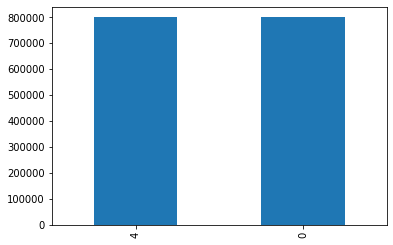

In [8]:
df['sentiment'].value_counts().plot.bar()

In [9]:
sentiments_cat = ['negative','neutral','postive']

In [23]:
def encode_corpus(corpus):
  words = ' '.join(corpus).split()
  
  count_words = Counter(words)
  total_words = len(words)

def count_words(corpus):
  words = ' '.join(corpus).split()
  
  counted_words = Counter(words)
  total_words = len(words)

  return total_words, counted_words

def sort_words(corpus):
  total_words, counted_words = count_words(corpus)
  return counted_words.most_common(total_words)

def decode_sentiments(encoded_sentiments, sentiments_cat=sentiments_cat, postive_index=2, 
                      negative_index=0, neutral_index=1):
  decoded_sentiments = []

  for index in range(0, len(encoded_sentiments)):
    if encoded_sentiments[index] == 0:
      decoded_sentiments.append(sentiments_cat[negative_index])
    elif encoded_sentiments[index] == 2:
      decoded_sentiments.append(sentiments_cat[neutral_index])
    elif encoded_sentiments[index] == 4 or encoded_sentiments[index] == 1:
      decoded_sentiments.append(sentiments_cat[postive_index])
  
  return decoded_sentiments

def convert_sentiments(sentiments):
  converted = []

  for s in sentiments:
    if s == 4:
      converted.append(1)
    else:
      converted.append(0)
  return np.array(converted)

In [17]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

def convert_to_lower(corpus):
    return [c.lower() for c in corpus]
    
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

def expand_contractions(text):
  expanded_words = []    
  for word in text.split():
    # using contractions.fix to expand the shotened words
    expanded_words.append(contractions.fix(word))   
      
  return' '.join(expanded_words)

In [18]:
sentiments = convert_sentiments(df['sentiment'].values)

In [19]:
sentiments = convert_sentiments(df['sentiment'].values)
corpus = convert_to_lower(df['text'].values)

In [20]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        
        # lemmatize text
        # if text_lemmatization:
        #     doc = lemmatize_text(doc)
        
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
            
            pat1 = r'@[A-Za-z0-9_]+'
            pat2 = r'https?://[^ ]+'
            www_pat = r'www.[^ ]+'
            combined_pat = r'|'.join((pat1, pat2))
            doc = re.sub(combined_pat, '', doc)
            doc = re.sub(www_pat, '', doc)

        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [21]:
normalized_corpus = normalize_corpus(corpus)

In [24]:
total_words = count_words(normalized_corpus)
sorted_words = sort_words(normalized_corpus)

In [25]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

In [ ]:
vocab_to_int

In [29]:
def tokenize(corpus):
  reviews_int = []
  for review in corpus:
      r = [vocab_to_int[w] for w in review.split()]
      reviews_int.append(r)
  return reviews_int

In [36]:
encoded = tokenize(normalized_corpus)
encoded_np = np.array(encoded)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [53]:
VOCAB_SIZE = total_words[0]
MAXLEN = 100

X_train, X_test, y_train, y_test = train_test_split(
    encoded, sentiments, test_size=0.33, random_state=42)
#we cannot pass different length data to the model, thus all must be the same so we normalise them with MAXLEN
#if the review is > maxlen, trim it, if not pad it with 0s 
X_train = sequence.pad_sequences(X_train, MAXLEN)
X_test = sequence.pad_sequences(X_test, MAXLEN)

In [55]:
len(X_train), len(X_test)

(1072000, 528000)

In [56]:
X_train[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0, 96113,   529,     1,     2,   836,
           9], dtype=int32)

In [64]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 32),
    tf.keras.layers.LSTM(125),
    tf.keras.layers.Dense(1),
    QReLU()
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          389356992 
_________________________________________________________________
lstm_4 (LSTM)                (None, 125)               79000     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 126       
_________________________________________________________________
q_re_lu_3 (QReLU)            (None, 1)                 0         
Total params: 389,436,118
Trainable params: 389,436,118
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['acc'])

history = model.fit(X_train, y_train, epochs=5, validation_split=0.3)

Train on 750400 samples, validate on 321600 samples
Epoch 1/5


In [ ]:
results = model.evaluate(X_test, y_test)
print(results)